# My First Data Analysis Project

I'll be working off the __[PJM Hourly Energy Consumption Data set](https://www.kaggle.com/robikscube/hourly-energy-consumption)__ found on Kaggle

In [1]:
#Import necessary libraries

import numpy as np #linear algebra
import pandas as pd #data processing, CSV file I/O
import matplotlib.pyplot as plt #MATLAB-style plotting
import seaborn as sns #creates pretty plots
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Import the data

df = pd.read_csv('PJM_Load_hourly.csv')

In [3]:
#Check the first 2 rows of the data set

df.head(2)

,Datetime,PJM_Load_MW
0,1998-12-31 01:00:00,29309.0
1,1998-12-31 02:00:00,28236.0


In [4]:
#Check the data types of the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32896 entries, 0 to 32895
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Datetime     32896 non-null  object 
 1   PJM_Load_MW  32896 non-null  float64
dtypes: float64(1), object(1)
memory usage: 514.1+ KB


In [5]:
#Check if there are any null or missing values 

df.isnull().sum()

Datetime       0
PJM_Load_MW    0
dtype: int64

There are no null values

In [6]:
#Convert the object column to a datetime column 

df['Datetime'] = pd.to_datetime(df.Datetime)

In [7]:
#Create new features to work with 

df['hour'] = df['Datetime'].dt.hour
df['dayofweek'] = df['Datetime'].dt.dayofweek
df['quarter'] = df['Datetime'].dt.quarter
df['month'] = df['Datetime'].dt.month
df['year'] = df['Datetime'].dt.year
df['dayofyear'] = df['Datetime'].dt.dayofyear
df['dayofmonth'] = df['Datetime'].dt.day
df['weekofyear'] = df['Datetime'].dt.weekofyear

In [8]:
#Assign recognizable names to the dayofweek feature

dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df['Day of Week']=df['dayofweek'].map(dmap)

In [9]:
#Assign recognizable names to the month feature

dmap = {12:'Dec',1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov'}
df['Month']=df['month'].map(dmap)

In [10]:
df.head(2) #making sure the mapping was correct

,Datetime,PJM_Load_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Day of Week,Month
0,1998-12-31 01:00:00,29309.0,1,3,4,12,1998,365,31,53,Thu,Dec
1,1998-12-31 02:00:00,28236.0,2,3,4,12,1998,365,31,53,Thu,Dec


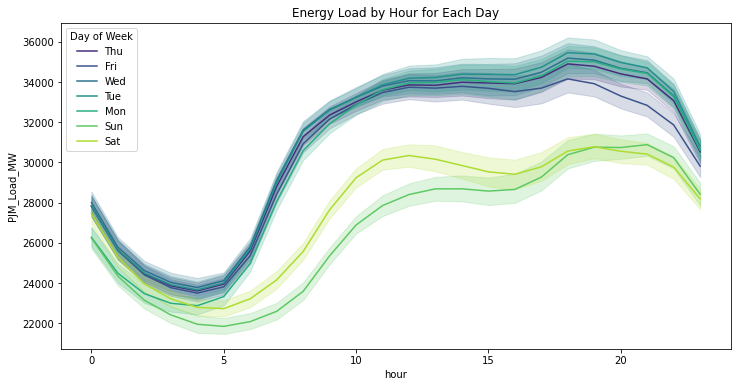

In [11]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="hour", y="PJM_Load_MW", hue="Day of Week", palette='viridis')
plt.title("Energy Load by Hour for Each Day")
plt.show()

Interesting that there is less energy used on Sunday and Saturday. Also, it's clearly shown the peak usage hours are in the evenings at 6pm-ish, when everyone is coming home from work and turning on their TVs and dishwashers and heaters/ACs. Proof that load shifting can be done to reduce the peak load on utilities and take opportunity of cheaper energy or more readily available off-hours. 

In [12]:
#Create a heatmap to visualize the same data another way

dayHour = df.groupby(by=['Day of Week','hour']).mean()['PJM_Load_MW'].unstack()

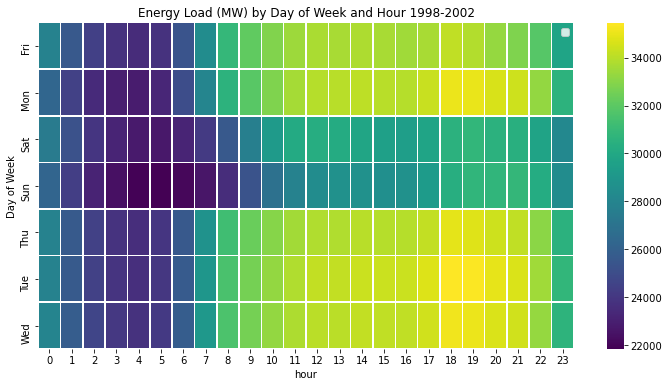

In [13]:
plt.figure(figsize=(12,6))
sns.heatmap(dayHour,cmap='viridis', linewidths=0.5)
plt.title("Energy Load (MW) by Day of Week and Hour 1998-2002")
plt.legend("Test")

Lowest energy use is on Sundays at around 4am, which is confirmed by our earlier plot

Text(0.5, 1.0, 'Energy Load by Month for Each Hour')

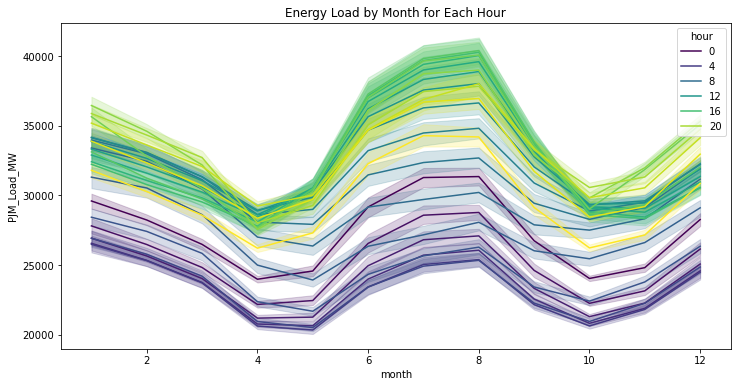

In [14]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="month", y="PJM_Load_MW", hue="hour", palette='viridis')
plt.title("Energy Load by Month for Each Hour")

My hypothesis is that the least energy is used on a Sunday in October

My hypothesis is that the most energy is used on a Thursday in August

Let's check these guesses!

In [15]:
df[df['PJM_Load_MW']==df['PJM_Load_MW'].max()]

,Datetime,PJM_Load_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Day of Week,Month
27607,2001-08-09 15:00:00,54030.0,15,3,3,8,2001,221,9,32,Thu,Aug


Correct! 

In [16]:
df[df['PJM_Load_MW']==df['PJM_Load_MW'].min()]

,Datetime,PJM_Load_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Day of Week,Month
5307,1998-05-24 05:00:00,17461.0,5,6,2,5,1998,144,24,21,Sun,May


Close! 

Text(0.5, 1.0, 'Energy Load by Day of Week 1998-2002')

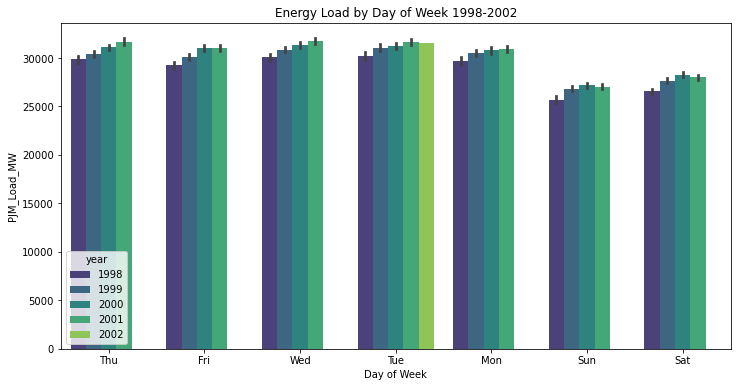

In [17]:
plt.figure(figsize=(12,6))
sns.barplot(x='Day of Week',y="PJM_Load_MW", data=df, hue='year', palette='viridis')
plt.title("Energy Load by Day of Week 1998-2002")

It makes sense that energy consumption increases as the years go on (global warming and also more appliances/modernization)

### Analysis

In [18]:
#Import necessary libraries

import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [19]:
#Compress the data set down into days in YMD format

df['YMD'] = df['Datetime'].dt.date
daily = df.groupby(by=['YMD']).mean()

#### Start by checking stationarity with the Dickey Fuller Test

In [20]:
print ('Results of Dickey-Fuller Test:')
adf_test = sts.adfuller(daily['PJM_Load_MW'],autolag='AIC')
dfoutput = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in adf_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -3.639219
p-value                           0.005054
#Lags Used                       22.000000
Number of Observations Used    1349.000000
Critical Value (1%)              -3.435207
Critical Value (5%)              -2.863685
Critical Value (10%)             -2.567912
dtype: float64


Since the P value is less than 0.05, this model is stationary. If it was not stationary, I would  need to find the proper p, d, and q values. I'll do that for the practice anyway though.

#### Finding the order of differencing (d)

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

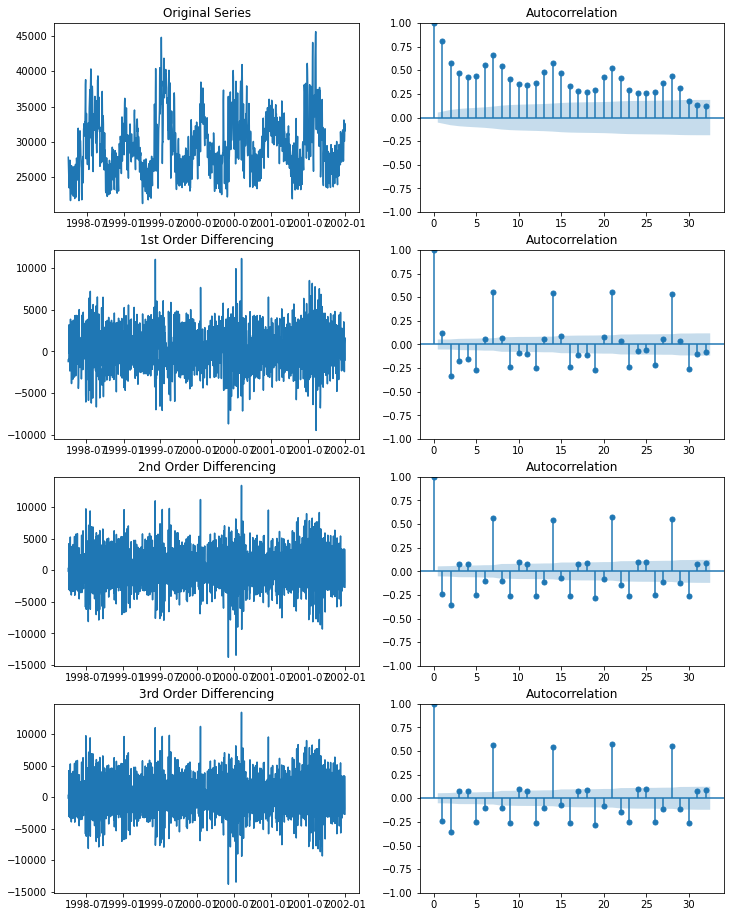

In [22]:
# Original Series
fig, axes = plt.subplots(4, 2, sharex=False, figsize=(12,16))
axes[0, 0].plot(daily.PJM_Load_MW); axes[0, 0].set_title('Original Series')
plot_acf(daily.PJM_Load_MW, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(daily.PJM_Load_MW.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(daily.PJM_Load_MW.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(daily.PJM_Load_MW.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(daily.PJM_Load_MW.diff().diff().dropna(), ax=axes[2, 1])

# 3rd Differencing
axes[3, 0].plot(daily.PJM_Load_MW.diff().diff()); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(daily.PJM_Load_MW.diff().diff().dropna(), ax=axes[3, 1])

plt.show()

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

Looks like a lot of the values immediately dropped to close to 0 in the 2nd order differencing, indicating we're close. The 3rd order differencing looks pretty similar to the 2nd order, so I'll just set d=1

#### Finding the order of the AR term (p)

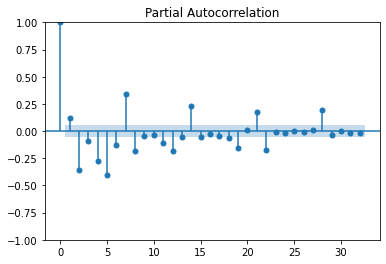

In [23]:
# PACF plot of 1st differenced series

plot_pacf(daily.PJM_Load_MW.diff().dropna())
plt.show()

Since the first two lags are above the significance line, we can set p=2

#### Finding the order of the MA term (q)

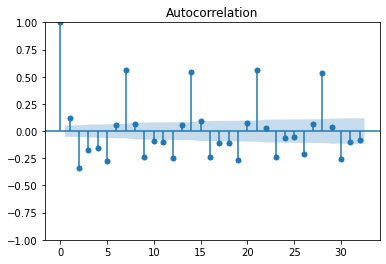

In [24]:
plot_acf(daily.PJM_Load_MW.diff().dropna())
plt.show()

The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

There are two lags above the significance line, so we can set q=2

#### Back to the analysis (building an ARIMA model)

In [25]:
#Split the test set and train set
#we'll use 80% of the dataframe as the test set, and the other 20% as the train set

size = int(len(daily)*0.8)
daily, daily_test = daily.iloc[:size], daily.iloc[size:]

In [26]:
#Fit a model

model_ar122 = ARIMA(daily.PJM_Load_MW, order=(1,2,2))
results_ar122 = model_ar122.fit()

/Users/aayushparekh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/aayushparekh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/aayushparekh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [27]:
start_date = "2001-04-02"
end_date = "2002-01-01"
daily_pred122 = results_ar122.predict(start = start_date, end = end_date)

In [28]:
#Fit a model with an order of 1,1,1

model_ar111 = ARIMA(daily.PJM_Load_MW, order=(1,1,1))
results_ar111 = model_ar111.fit()
daily_pred111 = results_ar111.predict(start = start_date, end = end_date)

/Users/aayushparekh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/aayushparekh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/aayushparekh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


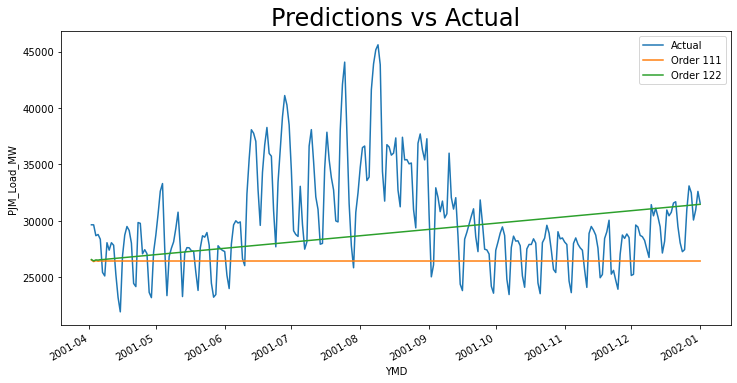

In [29]:
#Plot the results of the two models to see the forecast 

plt.figure(figsize=(12,6))
sns.lineplot(data=daily_test, x="YMD", y="PJM_Load_MW", palette='viridis')
daily_pred111[start_date:end_date].plot()
daily_pred122[start_date:end_date].plot()
plt.title("Predictions vs Actual", size = 24)
plt.legend(["Actual", "Order 111", "Order 122"])

#Order 111 is the model run with arguments (1,1,1)
#Order 122 is the model run with arguments (1,2,2)

Seems like by adding a small constant to the forecast, the accuracy can improve... sort of

In [30]:
#Generate accuracy metrics

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) 
    me = np.mean(forecast - actual)             
    mae = np.mean(np.abs(forecast - actual))    
    mpe = np.mean((forecast - actual)/actual)   
    rmse = np.mean((forecast - actual)**2)**.5  
    corr = np.corrcoef(forecast, actual)[0,1]   
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(daily_pred122, daily_test.PJM_Load_MW)

{'mape': 0.11356981535542576,
 'me': -1037.7544727779257,
 'mae': 3580.517337966894,
 'mpe': -0.014981505415065897,
 'rmse': 4854.378336024421,
 'corr': -0.04996119211012343,
 'minmax': 0.10699870811011625}

Around a 11% MAPE implies the model is about 89% accurate in predicting the next start_date:end_date number of events. It visually does not look like that's true, though

### Building an ARIMA Model

In [31]:
#Let ARIMA come up with the best tuning 

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(daily_test.PJM_Load_MW, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No seasonality (I know this is wrong for now)
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5099.405, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5114.773, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5110.625, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5104.868, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5112.776, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5053.343, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5083.737, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5055.579, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5056.472, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5054.734, Time=0.36 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5083.918, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5059.456, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5050.467, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5097.403, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]          

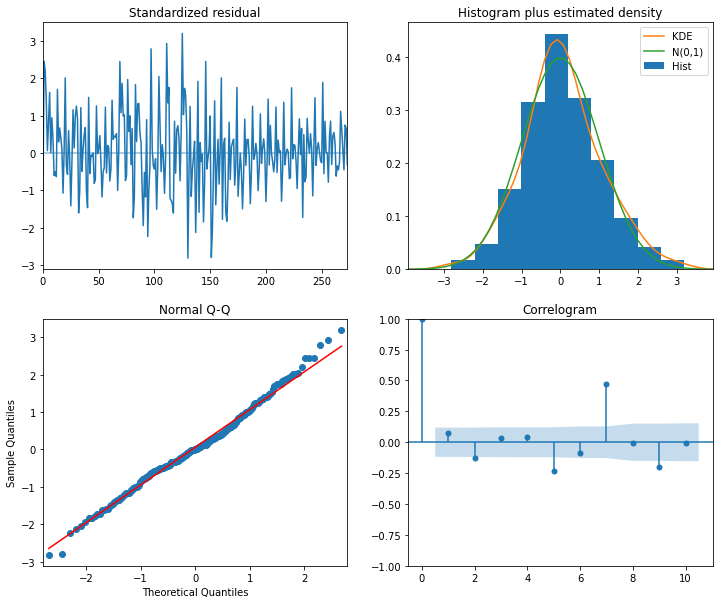

In [32]:
model.plot_diagnostics(figsize=(12,10))
plt.show()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.
 - it looks like there is a pattern at lag 7 that are not being explained by the model, I wonder if that's seasonality 

Overall, it seems to be a good fit. 

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [33]:
#Forecast

import matplotlib.dates as mdates
import datetime as dt

dates = mdates.num2date(mdates.drange(dt.datetime(2001, 4, 2),
                                      dt.datetime(2002, 1, 1),
                                      dt.timedelta(days=1)))
daily_pred = pd.Series(model.predict(n_periods=len(dates)), index=dates)

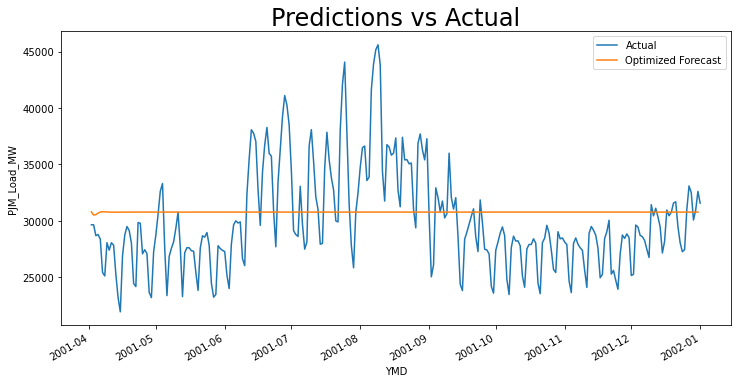

In [34]:
#Plot the results

plt.figure(figsize=(12,6))
sns.lineplot(data=daily_test, x="YMD", y="PJM_Load_MW", palette='viridis')
daily_pred.plot()
plt.title("Predictions vs Actual", size = 24)
plt.legend(["Actual", "Optimized Forecast"])
plt.show()

This..is not correct or close. I must be missing the seasonal component. Time to build a SARIMA model

### Building a SARIMA Model

In [35]:
import pmdarima as pm

In [36]:
#Create a model

smodel = pm.auto_arima(daily_test.PJM_Load_MW, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=4,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[4] intercept   : AIC=5071.065, Time=0.37 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=5388.893, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=5124.217, Time=0.16 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=5098.567, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=5386.932, Time=0.01 sec
 ARIMA(1,0,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,1)(1,1,1)[4] intercept   : AIC=5072.900, Time=0.46 sec
 ARIMA(1,0,1)(0,1,2)[4] intercept   : AIC=5072.981, Time=0.55 sec
 ARIMA(1,0,1)(1,1,0)[4] intercept   : AIC=5102.196, Time=0.32 sec
 ARIMA(1,0,1)(1,1,2)[4] intercept   : AIC=5074.083, Time=0.53 sec
 ARIMA(1,0,0)(0,1,1)[4] intercept   : AIC=5100.608, Time=0.36 sec
 ARIMA(2,0,1)(0,1,1)[4] intercept   : AIC=5072.805, Time=0.19 sec
 ARIMA(1,0,2)(0,1,1)[4] intercept   : AIC=5072.984, Time=0.35 sec
 ARIMA(0,0,0)(0,1,1)[4] intercept   : AIC=5282.741, Time=0.12 sec
 ARIMA(0,0,2)(0,1,1)[4] intercept   : 

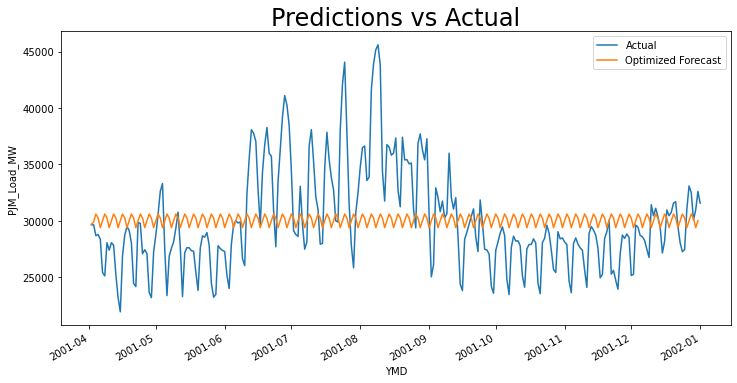

In [37]:
#Forecast

dates = mdates.num2date(mdates.drange(dt.datetime(2001, 4, 2),
                                      dt.datetime(2002, 1, 1),
                                      dt.timedelta(days=1)))
daily_pred = pd.Series(smodel.predict(n_periods=len(dates)), index=dates)

#Plot the results

plt.figure(figsize=(12,6))
sns.lineplot(data=daily_test, x="YMD", y="PJM_Load_MW", palette='viridis')
daily_pred.plot()
plt.title("Predictions vs Actual", size = 24)
plt.legend(["Actual", "Optimized Forecast"])
plt.show()

That did something! Looks like the forecast is on some sort of repetition forever, and it doesn't seem to understand the seasonality either. 

I wonder if I should compress the data from daily to monthly and try running SARIMA again

### Making a new data set for monthly data 

In [38]:
#Compress the data set down into months, and remove some of the features I made

monthly = df.copy()
monthly.drop(['hour', 'dayofweek', 'quarter', 'dayofyear', 'dayofmonth', 'weekofyear', 'Day of Week', 'month', 'Month', 'year'], axis=1, inplace=True)

In [39]:
monthly['Date']=monthly['Datetime'].dt.to_period('M')

In [40]:
monthly = monthly.groupby(by=['Date']).mean()
monthly.reset_index(inplace=True)

In [41]:
#Checking stationarity with the Dickey Fuller Test

print ('Results of Dickey-Fuller Test:')
adf_test = sts.adfuller(monthly['PJM_Load_MW'],autolag='AIC')
dfoutput = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in adf_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -7.745653e+00
p-value                        1.033708e-11
#Lags Used                     2.000000e+00
Number of Observations Used    4.300000e+01
Critical Value (1%)           -3.592504e+00
Critical Value (5%)           -2.931550e+00
Critical Value (10%)          -2.604066e+00
dtype: float64


Since the P value is less than 0.05, this model is stationary

In [42]:
#Split the test set and train set (80-20 split)

size = int(len(monthly)*0.8)
monthly, monthly_test = monthly.iloc[:size], monthly.iloc[size:]

In [43]:
#Create a model

smodel = pm.auto_arima(monthly.PJM_Load_MW, start_p=1, start_q=1,
                         test='adf',
                         max_p=5, max_q=5, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=425.405, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=422.240, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=424.713, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=424.583, Time=0.03 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=422.663, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=422.416, Time=0.02 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=424.241, Time=0.01 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=424.950, Time=0.01 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=425.258, Time=0.07 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=424.209, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.480 seconds


In [44]:
#Forecast

monthly_test['Date']=monthly_test['Date'].dt.to_timestamp()

index_list = monthly_test['Date']
monthly_pred = smodel.predict(n_periods=len(index_list))
monthly_pred = pd.DataFrame(monthly_pred, index=index_list)

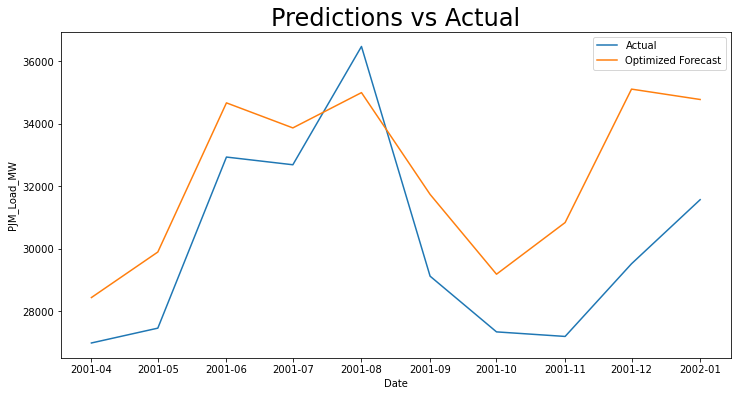

In [45]:
#Plot the results

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_test, x='Date', y='PJM_Load_MW')
plt.plot(monthly_pred)

plt.title("Predictions vs Actual", size = 24)
plt.legend(["Actual", "Optimized Forecast"])
plt.show()

Finally! A forecast that looks decent! It seems to be overestimating, not sure how to fix that at the moment, but I'm going to stop here and enjoy this result. 

It does annoy me though that the two dataframes aren't formatted the same, but I'm too tired to figure it out right now. 

TODO: 
accuracy metrics